# Titanic Model Comparison

### Sources

- https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- http://aplunket.com/titanic-comparing-models/

In [2]:
%matplotlib inline
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas,xgboost

Thu Jun 28 2018 

CPython 3.6.5
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.1
xgboost 0.72

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)
system     : Darwin
release    : 17.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [3]:
#Data manipulation tools
import pandas as pd
import numpy as np

In [4]:
df_train = pd.read_csv('/Users/patornute/.kaggle/competitions/titanic/train.csv')
df_test = pd.read_csv('/Users/patornute/.kaggle/competitions/titanic/test.csv')

In [5]:
df_total = df_train.append(df_test)

/Users/patornute/.pyenv/versions/3.6.5/envs/latest/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Data Cleansing & Data Preprocessing

In [11]:
#The survived column doesn't exist in the test set so find the train data from looking for NaN values
df_total['Train'] = df_total['Survived'].apply(lambda x:0 if np.isnan(x) else 1) 

#Update NaN values
df_total['Age'] = df_total['Age'].fillna(df_total['Age'].mean())
df_total['Fare'] = df_total['Fare'].fillna(df_total['Fare'].mean())
df_total['Embarked'] = df_total['Embarked'].fillna(df_total['Embarked'].mode()[0])

#Create Title variable from the Name field
df_total['Title'] = df_total['Name'].str.split(".").str[0]
df_total['Title'] = df_total['Title'].str.split(" ").str[-1]

df_total.drop('Name', axis=1, inplace=True)

def updateTitle(s):
    if s in ['Mlle', 'Ms', 'Mme']:
        return 'Miss'
    elif s in ['Mr', 'Miss', 'Mrs', 'Master']:
        return s
    else:
        return 'Other'

df_total['Title'] = df_total['Title'].apply(lambda x: updateTitle(x))

#Create FamilySize variable
df_total['FamilySize'] = df_total['SibSp'] + df_total['Parch'] 
df_total.drop('SibSp', axis=1, inplace=True)
df_total.drop('Parch', axis=1, inplace=True)
df_total['FamilySize'] = df_total['FamilySize'].apply(lambda x: 4 if x > 4 else x)

#Get the first character of the Ticket variable
df_total['Ticket'] = df_total['Ticket'].str[0:1]

#Get the first character of the Cabin variable and replace NaN with Unknown
df_total['Cabin'] = df_total['Cabin'].str[0]
df_total['Cabin'] = df_total['Cabin'].fillna(df_total['Cabin'].mode()[0])

# Scale Age, Fare and Family Size Variables

In [14]:
#Scale Age, Fare and Family Size Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

scale_columns = ['Age', 'Fare', 'FamilySize']
df_total_s = sc.fit_transform(df_total[scale_columns])
df_total_s = pd.DataFrame((df_total_s), columns=scale_columns, index=df_total.index.get_values())

#add the scaled columns back into the dataframe
df_total[scale_columns] = df_total_s

#One-Hot Encode Data
df_total = pd.get_dummies(df_total, drop_first=True)

# Create X_train, y_train and X_test variables

In [18]:
X_train = df_total[df_total['Train'] == 1].drop(['Survived', 'PassengerId', 'Train'], axis=1)
y_train = df_total[df_total['Train'] == 1]['Survived']

X_test = df_total[df_total['Train'] == 0].drop(['Survived', 'PassengerId', 'Train'], axis=1)

In [22]:
X_test.head()

,Age,Fare,Pclass,FamilySize,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,...,Ticket_C,Ticket_F,Ticket_L,Ticket_P,Ticket_S,Ticket_W,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0.358655,-0.492396,3,-0.659690,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.329283,-0.508429,3,0.195294,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.494035,-0.456465,2,-0.659690,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.223721,-0.476284,3,-0.659690,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.611972,-0.406194,3,1.050278,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Model Comparison

In [23]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [24]:
def tune_score_model(model, param_grid, X, y, n_jobs=-1, cv=3):
    
    #Runs a GridSearchCV for the model and param_grid passed into the function
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=n_jobs, verbose=1, cv=cv)
    grid.fit(X_train, y_train)
    
    #Returns the best score and params used to get the score
    return grid.best_score_, grid.best_params_

In [25]:
#List of Model Names and a True / False value that specifies whether to run the model or not
models = [
          ['AdaBoost', True],
          ['Extra Trees', True],
          ['Random Forest', True], 
          ['Voting Classifier', True],
          ['XGBoost', True] 
         ]

#Models to run along with any variables that we want to specify
model_obj = [
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1, n_estimators=500, random_state=29),
    
          ExtraTreesClassifier(random_state=29),
    
          RandomForestClassifier(random_state=29), 
    
          VotingClassifier(estimators=[('lr', LogisticRegression(random_state=29)),
                            ('nb', GaussianNB()),
                            ('knn', KNeighborsClassifier()),
                            ('rf', RandomForestClassifier(random_state=29, n_estimators=500))],
                           voting='soft'
                          ),
    
          XGBClassifier(learning_rate=0.1, n_estimators=500, objective='binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=29,
                        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1) #These three probably need to be tuned further
          
         ]

#The param_grid values for each of the models
param_grids = [
               #AdaBoost
               {"base_estimator__criterion": ["gini", "entropy"],
                "base_estimator__min_samples_split": [2, 10, 20],
                "base_estimator__max_depth": [1, 2, 5, 10],
                "base_estimator__min_samples_leaf": [1, 5, 10],
                "base_estimator__max_leaf_nodes": [None, 5, 10, 20]},
               #Extra Trees
               {"n_estimators": [200, 500],
                "max_depth": [3, None],
                "max_features": [1, 3, 5, 10],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [True, False],
                "criterion": ['gini', 'entropy']},
               #Random Forest
               {"n_estimators": [200, 500],
                "max_depth": [3, None],
                "max_features": [1, 3, 5, 10],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [True, False],
                "criterion": ['gini', 'entropy']},
               #VotingClassifier
               {"lr__penalty": ['l1', 'l2'],
                "lr__C": [1, 10, 100],
                "rf__max_depth": [3, 5, None],
                "rf__criterion": ['gini', 'entropy'],
                "knn__n_neighbors": [3,5,7,9],
                "knn__weights": ['uniform', 'distance']
               },
               #XGBoost
               {'max_depth':range(3,10,1),
                'min_child_weight':range(1,6,1), 
                'gamma':[i/10.0 for i in range(0,7)]}
              ]

#Initialize as empty lists
best_scores = []
best_params = []

#Look through all the models and run the tune_score_model function (if set to True). 
#The results of the function are saved to the best_scores and best_params lists
n_out = 0
for i in range(len(model_obj)):  
    if models[i][1]:
        best_scores.append(n_out)
        best_params.append(n_out)
        print(models[i][0])
        best_scores[n_out], best_params[n_out] = tune_score_model(model_obj[i], param_grids[i], X_train, y_train, n_jobs=-1)
        n_out = n_out + 1

AdaBoost
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.3min finished


Extra Trees
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.0min finished


Random Forest
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.3min finished


Voting Classifier
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.7min finished


XGBoost
Fitting 3 folds for each of 245 candidates, totalling 735 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed:  2.0min finished


In [26]:
model_output = pd.DataFrame(
    {'models': [val for val, is_true in models if is_true], 
     'best_scores': best_scores, 'best_params': best_params}, 
    columns=['models', 'best_scores', 'best_params']).sort_values(by='best_scores', ascending=False)
model_output

,models,best_scores,best_params
2,Random Forest,0.879286,"{'bootstrap': False, 'criterion': 'gini', 'max..."
1,Extra Trees,0.879102,"{'bootstrap': False, 'criterion': 'gini', 'max..."
4,XGBoost,0.877313,"{'gamma': 0.5, 'max_depth': 4, 'min_child_weig..."
3,Voting Classifier,0.876658,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo..."
0,AdaBoost,0.867414,"{'base_estimator__criterion': 'entropy', 'base..."


# Submission

In [27]:
best_params[4]

{'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5}

In [28]:
classifier = XGBClassifier(learning_rate =0.01, 
                      n_estimators=5000, 
                      max_depth=8,
                      min_child_weight=5, 
                      gamma=0.6, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      reg_alpha=1e-05,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.6, learning_rate=0.01,
       max_delta_step=0, max_depth=8, min_child_weight=5, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=29, silent=True, subsample=0.8)

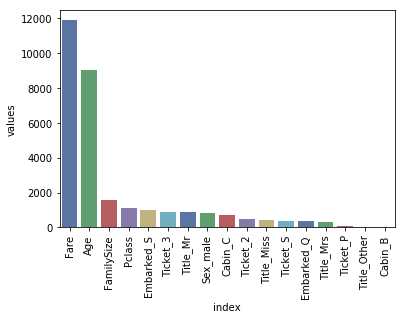

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_import = pd.DataFrame.from_dict(classifier.get_booster().get_fscore(), orient='index')
feature_import.columns = ['values']
feature_import.sort_values(['values'], ascending=False, inplace=True)
feature_import.reset_index(level=0, inplace=True)
sns.barplot(x='index', y='values', data=feature_import, palette='deep')
plt.xticks(rotation=90)
plt.show()

In [32]:
y_pred = classifier.predict(X_test)

/Users/patornute/.pyenv/versions/3.6.5/envs/latest/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
output = pd.DataFrame(y_pred, columns=['Survived']).astype(int)
output['PassengerId'] = df_total[df_total['Train'] == 0]['PassengerId']
output.to_csv('XGBoost.csv', index=False)

# Extra: Tuning XGBoost 

In [13]:
# Next, we will tune the n_estimators

param_grid0 = {'n_estimators': [100, 200, 300, 400, 500]}

model = XGBClassifier(learning_rate =0.1, 
                      max_depth=5,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

grid0 = GridSearchCV(estimator=model, param_grid=param_grid0, scoring='roc_auc', n_jobs=-1, verbose=2)
grid0.fit(X_train, y_train)

print(grid0.best_score_)
print(grid0.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=300 ................................................
[CV] n_estimators=300 ................................................


KeyboardInterrupt: 

In [12]:
# Next, we will tune the max_depth and min_child_weight

param_grid1 = {'max_depth':range(3,10,1),
               'min_child_weight':range(1,6,1)}

model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=100, 
                      max_depth=5,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

grid1 = GridSearchCV(estimator=model, param_grid=param_grid1, scoring='roc_auc', n_jobs=-1, verbose=2)
grid1.fit(X_train, y_train)

print(grid1.best_score_)
print(grid1.best_params_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


KeyboardInterrupt: 

In [ ]:
# Next, we will tune gamma using the values for max_depth (4) and min_child_weight (5) that we found

param_grid2 = {'gamma':[i/10.0 for i in range(0,7)]}

model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=100, 
                      max_depth=4,
                      min_child_weight=5, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

grid2 = GridSearchCV(estimator=model, param_grid=param_grid2, scoring='roc_auc', n_jobs=-1, verbose=1)
grid2.fit(X_train, y_train)

print(grid2.best_score_)
print(grid2.best_params_)

In [ ]:
# Next, we will tune subsample and colsample_bytree using the gamma value we found (0.0) as well as the values for max_depth and min_child_weight

param_grid3 = {'subsample':[i/100.0 for i in range(60,100,5)],
               'colsample_bytree':[i/100.0 for i in range(60,100,5)]}

model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=100, 
                      max_depth=4,
                      min_child_weight=5, 
                      gamma=0.0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

grid3 = GridSearchCV(estimator=model, param_grid=param_grid3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid3.fit(X_train, y_train)

print(grid3.best_score_)
print(grid3.best_params_)

In [ ]:
# Finally, we will tune reg_alpha

param_grid4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=100, 
                      max_depth=4,
                      min_child_weight=5, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.95,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29)

grid4 = GridSearchCV(estimator=model, param_grid=param_grid4, scoring='roc_auc', n_jobs=-1, verbose=1)
grid4.fit(X_train, y_train)

print(grid4.best_score_)
print(grid4.best_params_)